In [1]:
import torch
import numpy as np

# Assume the following modules are defined in your repository:
from causal_cocycle.kernels_new import GaussianKernel
from causal_cocycle.regression_functionals import NWFunctional 
from causal_cocycle.distribution_estimation import ConditionalExpectationRegressor  
from causal_cocycle.conditioners_new import NWConditioner  # NWConditioner defined earlier
from causal_cocycle.transformers_new import KREpsLayer  # Your KR transformer layer
from causal_cocycle.model_new import CocycleModel   # Your CocycleModel class

In [2]:
"""
working KR map function
"""
def build_KR_map(X: torch.Tensor, Y: torch.Tensor, 
                                                   w_src: torch.Tensor = None, w_tgt: torch.Tensor = None, epsilon: float = 1e-8):

    # Get weights if not provided
    if w_src is None:
        n_src = X.numel()
        w_src = torch.ones(n_src, device=X.device) / n_src
    if w_tgt is None:
        n_tgt = Y.numel()
        w_tgt = torch.ones(n_tgt, device=Y.device) / n_tgt
    
    # Sort X and Y first
    X_sorted_full, idx_X = torch.sort(X)
    Y_sorted_full, idx_Y = torch.sort(Y)
    w_src_sorted_full = w_src[idx_X]
    w_tgt_sorted_full = w_tgt[idx_Y]
    
    # Get unique sorted values for X, and sum the weights of duplicates.
    X_sorted, inverse_idx_X = torch.unique(X_sorted_full, sorted=True, return_inverse=True)
    w_src_sorted = torch.zeros_like(X_sorted, dtype=w_src.dtype)
    w_src_sorted = w_src_sorted.scatter_add_(0, inverse_idx_X, w_src_sorted_full)
    
    # Do the same for Y.
    Y_sorted, inverse_idx_Y = torch.unique(Y_sorted_full, sorted=True, return_inverse=True)
    w_tgt_sorted = torch.zeros_like(Y_sorted, dtype=w_tgt.dtype)
    w_tgt_sorted = w_tgt_sorted.scatter_add_(0, inverse_idx_Y, w_tgt_sorted_full)
    
    # Normalize the weights.
    w_src_sorted = w_src_sorted / w_src_sorted.sum()
    w_tgt_sorted = w_tgt_sorted / w_tgt_sorted.sum()
    
    def S(z):
        z = z.double()
        if epsilon == 0:
            return (z>=0).float()
        else:
            return torch.where(z < -epsilon, torch.zeros_like(z),
                               torch.where(z > epsilon, torch.ones_like(z),
                                           (z + epsilon) / (2 * epsilon)))
    def F_src(y):
        if not isinstance(y, torch.Tensor):
            y = torch.tensor(y, device=X_sorted.device)
        if y.dim() == 0:
            y = y.unsqueeze(0)
        if y.dim() == 1:
            y = y.unsqueeze(1)
        X_exp = X_sorted.unsqueeze(0)
        S_vals = S(y - X_exp)
        return torch.sum(w_src_sorted * S_vals, dim=-1)
        
    def Q_tgt(t):
        if not isinstance(t, torch.Tensor):
            t = torch.tensor(t, device=Y_sorted.device)
        if t.dim() > 1:
            t = t.squeeze(-1)
        cumsum = torch.cumsum(w_tgt_sorted, dim=0)
        indices = torch.searchsorted(cumsum, t.unsqueeze(1)).squeeze(1)
        indices = torch.clamp(indices, 0, Y_sorted.numel()-1)
        j = indices-1
        j_next = indices
        cumsum = torch.concatenate((torch.zeros(1),cumsum))
        cumsum_j = cumsum[j+1]
        w_j_next = w_tgt_sorted[j_next]
        s = (t - cumsum_j) / w_j_next
        Y_j_next = Y_sorted[j_next].double()
        Y_prev = Y_sorted[torch.clamp(j, min=0)].double()
        return Y_j_next - epsilon + 2 * epsilon * s
        
    def KR(y):
        t_val = F_src(y)
        return Q_tgt(t_val)
    return KR, F_src, Q_tgt

In [3]:
"""
Getting Cocycle model and predictions
"""
# -----------------------------
# 1. Load or generate observational and interventional data.
# Here we assume:
#   X_train: features (shape: (n_train, d)) used for the conditional distribution
#   Y_train: 1D tensor of SORTED UNIQUE outcomes (length n_train)
#   X_int: features of interventional data (shape: (n_int, d))
# (For illustration, we generate synthetic data.)

n_train = 5
d = 1
n_int = 5

# Generate synthetic observational data.
# (Here we sample uniformly and sort Y_train; your DGP will provide these.)
X_train_np = np.random.uniform(0, 1, size=(n_train, d))
Y_train_np = np.sort(np.random.uniform(0, 1, size=n_train))  # ensure sorted unique outcomes
# Convert to torch tensors.
X_train = torch.tensor(X_train_np, dtype=torch.float64)
Y_train = torch.tensor(Y_train_np, dtype=torch.float64)
# Generate interventional features.
X_int_np = np.random.uniform(0, 1, size=(n_int, d))
X_int = torch.tensor(X_int_np, dtype=torch.float64)

# -----------------------------
# 2. Determine a suitable epsilon.
# We choose epsilon to be a fraction (e.g., 1/10) of the smallest gap between successive Y_train values.
gaps = Y_train[1:] - Y_train[:-1]
min_gap = gaps.min()
epsilon = min(min_gap / 10,1e-6)
print("Selected epsilon:", epsilon)

# -----------------------------
# 3. Instantiate the NWConditioner.
# Here we create a GaussianKernel with an initial lengthscale (you may tune this further or optimize it).
kernel = GaussianKernel(lengthscale=torch.ones(d)/10)
functional = NWFunctional(kernel=kernel, reg=0.0)
CER = ConditionalExpectationRegressor(functional)

# The optimiser will use your NWFunctional’s hyperparameter list, which in this case is [kernel.log_lengthscale].
print("Starting hyperparameter optimisation...")
test_points = torch.linspace(Y_train.min()-0.1, Y_train.max()+0.1, 100)[:,None]
feature = (Y_train[:,None] <= test_points.T).float()
losses = CER.optimise(X_train, feature, maxiter=10, nfold=5, learn_rate=1e-2, print_=True,
                    subsamples = 512)
# -----------------------------
# 4. Instantiate the KR transformer layer and NWconditioner.
#kernel = GaussianKernel(lengthscale=torch.ones(d)/d**0.5)
conditioner = NWConditioner(X_train, kernel)

# -----------------------------
# 4. Instantiate the KR transformer layer.
# Y_train is assumed to be sorted and unique.
transformer = KREpsLayer(Y_train, epsilon)

# -----------------------------
# 5. Build the KR-cocycle model using the CocycleModel class.
# The CocycleModel class (from your uploaded files, e.g. model_builder.py)
# is assumed to accept a conditioner and transformer as components.
model = CocycleModel(conditioner=conditioner, transformer=transformer)

# -----------------------------
# 6. Compute counterfactual predictions.
# The typical API is:
#    model.cocycle(X_int, X_train, Y_train)
# This function should internally compute weights from the observational features,
# learn a mapping via the transformear (using the backward function to get the cumulative probability)
# and then apply the forward mapping to the interventional features.
cf_predictions = model.cocycle(X_int * 0 + 0.25, X_train * 0 + 0.75, Y_train[:,None])

Selected epsilon: 1e-06
Starting hyperparameter optimisation...
[iter 0] avg CV loss: 0.322763
lengthscale: tensor([0.1010], grad_fn=<ExpBackward0>)


Difference in predictions: tensor(3.4972e-16, dtype=torch.float64, grad_fn=<MeanBackward0>)


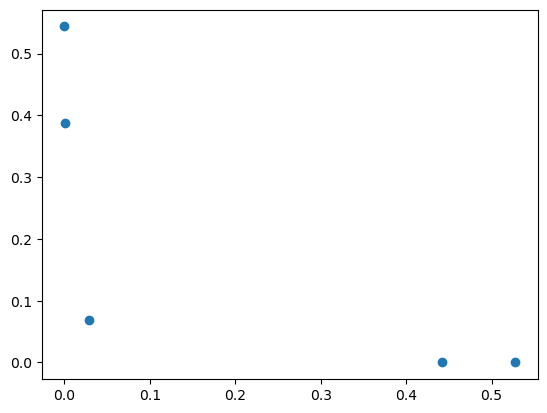

In [4]:
"""
Comparing with working KR map
"""
import matplotlib.pyplot as plt
weights_int = conditioner(X_int * 0+0.25)
weights_train = conditioner(X_train * 0 + 0.75)
plt.scatter(weights_train[0].detach(),weights_int[0].detach())
KR,F,Q = build_KR_map(Y_train, Y_train, weights_train[0], weights_int[0], epsilon)
print("Difference in predictions:",(KR(Y_train[:,None])-cf_predictions).abs().mean())

In [5]:
"""
Comparison in continuous input case
"""
import matplotlib.pyplot as plt
cf_predictions = model.cocycle(X_int, X_train, Y_train[:,None])
weights_int = conditioner(X_int )
weights_train = conditioner(X_train)
KRpreds = torch.tensor([build_KR_map(Y_train, Y_train, weights_train[i], weights_int[i], epsilon)[0](Y_train[i,None]) for i in range(n_int)])
print("Difference in predictions:",(KRpreds-cf_predictions).abs().sum())

Difference in predictions: tensor(3.8550e-13, dtype=torch.float64, grad_fn=<SumBackward0>)


In [6]:
"""
Two datasets under binary conditions
"""
class AggregateNWConditioner(torch.nn.Module):
    def __init__(self, kernels, X_splits, domain_key="D", feature_key="X"):
        super().__init__()
        self.conditioners = torch.nn.ModuleList([
            NWConditioner(X, k) for X, k in zip(X_splits, kernels)
        ])
        self.domain_key = domain_key
        self.feature_key = feature_key
        self.n = 0
        for split in X_splits:
            self.n += len(split)
        self.ids = torch.zeros(self.n)
        start,end = 0,0
        for d in range(len(X_splits)):
            end += len(X_splits[d])
            self.ids[start:end] = d
            start = end

    def forward(self, input_dict):
        X_query = input_dict[self.feature_key]
        D_query = input_dict[self.domain_key]
        
        weights_list = []
        for d in range(len(self.conditioners)):
            mask = (D_query == d)
            if mask.sum() > 0:
                theta = self.conditioners[d](X_query[mask])
                weights_full = torch.zeros((mask.sum(), self.n), device=theta.device).double()
                idx_map = torch.where(self.ids == d)[0]
                weights_full[:, idx_map] = theta
                weights_list.append((mask, weights_full))

        output = torch.zeros((X_query.shape[0], self.n), device=X_query.device).double()
        for mask, weighted_block in weights_list:
            output[mask] = weighted_block
        print(output)
        return output


n_train = 100
d = 1
n_int = 100

X_train = torch.ones(n_train, dtype=torch.float64).unsqueeze(-1)
Y_train = torch.tensor(np.sort(np.random.uniform(0, 1, size=n_train)) , dtype=torch.float64)
D_train = torch.zeros(n_train, dtype=torch.float64)

X_int = torch.ones(n_train, dtype=torch.float64).unsqueeze(-1)
Y_int = torch.tensor(np.sort(np.random.uniform(0, 1, size=n_train)) , dtype=torch.float64)
D_int = torch.ones(n_train, dtype=torch.float64)

inputs_train = {'X': X_train,
                'D': D_train}

inputs_int = {'X': X_int,
                'D': D_int}

X_splits = [X_train,X_int]
Y_splits = [Y_train,Y_int]

In [7]:
# working KR map
KR_preds = build_KR_map(Y_train, Y_int, epsilon = epsilon)[0](Y_train[:,None])

# cocycle
conditioner = AggregateNWConditioner([kernel]*2,X_splits)
transformer = KREpsLayer(torch.cat(Y_splits), epsilon)
model = CocycleModel(conditioner=conditioner, transformer=transformer)
cocycle_preds = model.cocycle(inputs_int, inputs_train, Y_train)
print("Difference in predictions:",(KR_preds-cocycle_preds).abs().sum())

tensor([[0.0100, 0.0100, 0.0100,  ..., 0.0000, 0.0000, 0.0000],
        [0.0100, 0.0100, 0.0100,  ..., 0.0000, 0.0000, 0.0000],
        [0.0100, 0.0100, 0.0100,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.0100, 0.0100, 0.0100,  ..., 0.0000, 0.0000, 0.0000],
        [0.0100, 0.0100, 0.0100,  ..., 0.0000, 0.0000, 0.0000],
        [0.0100, 0.0100, 0.0100,  ..., 0.0000, 0.0000, 0.0000]],
       dtype=torch.float64, grad_fn=<IndexPutBackward0>)
tensor([[0.0000, 0.0000, 0.0000,  ..., 0.0100, 0.0100, 0.0100],
        [0.0000, 0.0000, 0.0000,  ..., 0.0100, 0.0100, 0.0100],
        [0.0000, 0.0000, 0.0000,  ..., 0.0100, 0.0100, 0.0100],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.0100, 0.0100, 0.0100],
        [0.0000, 0.0000, 0.0000,  ..., 0.0100, 0.0100, 0.0100],
        [0.0000, 0.0000, 0.0000,  ..., 0.0100, 0.0100, 0.0100]],
       dtype=torch.float64, grad_fn=<IndexPutBackward0>)
Difference in predictions: tensor(1.9372e-10, dtype=torch.float64, grad_fn=<SumBackward0>)

In [13]:
"""
Two datasets but conditional cdfs being used (i.e. KR_{(1,x'),(0,x))(y)
"""
n_train = 100
d = 1
n_int = 100

X_train = torch.randn(n_train, dtype=torch.float64).unsqueeze(-1)
Y_train = torch.tensor(np.sort(np.random.uniform(0, 1, size=n_train)) , dtype=torch.float64)
D_train = torch.zeros(n_train, dtype=torch.float64)
mapped_X_train = torch.randn(n_train, dtype=torch.float64).unsqueeze(-1)

X_int = torch.randn(n_train, dtype=torch.float64).unsqueeze(-1)
Y_int = torch.tensor(np.sort(np.random.uniform(0, 1, size=n_train)) , dtype=torch.float64)
D_int = torch.ones(n_train, dtype=torch.float64)

inputs_train = {'X': X_train,
                'D': D_train}

inputs_int = {'X': mapped_X_train,
                'D': D_int}

X_splits = [X_train,X_int]
Y_splits = [Y_train,Y_int]

In [14]:
# working KR map
conditioner_train = NWConditioner(X_train, kernel)
conditioner_int = NWConditioner(X_int, kernel)

KR_preds = torch.tensor([build_KR_map(Y_train, Y_int, conditioner_train(X_train[i:i+1,:])[0], conditioner_int(mapped_X_train[i:i+1,:])[0], epsilon = epsilon)[0](Y_train[i,None]) for i in range(n_int)])

# cocycle
conditioner = AggregateNWConditioner([kernel]*2,X_splits)
transformer = KREpsLayer(torch.cat(Y_splits), epsilon)
model = CocycleModel(conditioner=conditioner, transformer=transformer)
cocycle_preds = model.cocycle(inputs_int, inputs_train, Y_train)
print("Difference in predictions:",(KR_preds-cocycle_preds).abs().sum())

tensor([[1.0038e-01, 8.7513e-07, 4.7676e-02,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [8.3265e-07, 9.5504e-02, 1.4295e-04,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [4.9636e-02, 1.5642e-04, 1.0450e-01,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        ...,
        [2.2020e-06, 3.5213e-21, 3.6151e-09,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [3.3757e-48, 1.6926e-22, 9.5710e-41,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [1.9030e-04, 5.2766e-02, 7.1236e-03,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00]], dtype=torch.float64, grad_fn=<IndexPutBackward0>)
tensor([[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  2.2396e-26,
          1.7037e-68,  6.1849e-02],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  2.8989e-68,
         3.9139e-131,  2.7459e-09],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  6.1837e-08,
          3.4928e-34,  6.5932e-10],
        ...,
        [ 0.0000e+00,  0.0000e+0

In [17]:
from causal_cocycle.conditioners_new import CompositeConditioner
comp_conditioner = CompositeConditioner(layers = [conditioner])
model_new = CocycleModel(comp_conditioner,transformer)
cocycle_preds = model_new.cocycle(inputs_int, inputs_train, Y_train)
print("Difference in predictions:",(KR_preds-cocycle_preds).abs().sum())

tensor([[1.0038e-01, 8.7513e-07, 4.7676e-02,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [8.3265e-07, 9.5504e-02, 1.4295e-04,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [4.9636e-02, 1.5642e-04, 1.0450e-01,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        ...,
        [2.2020e-06, 3.5213e-21, 3.6151e-09,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [3.3757e-48, 1.6926e-22, 9.5710e-41,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [1.9030e-04, 5.2766e-02, 7.1236e-03,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00]], dtype=torch.float64, grad_fn=<IndexPutBackward0>)


TypeError: only integer tensors of a single element can be converted to an index